In [1]:
date = "241031"
box1 = "16"
box2 = "17"
exp  = "WT_ALDH7A1_PTZ"
name = date+"_"+box1+"_"+box2+"_"+exp
path = name+"/"

singlebox = False


In [344]:
date = "241107"
box1 = "16"
box2 = "17"
exp  = "PNPO_PTZ"
name = date+"_"+box1+"_"+box2+"_"+exp
path = name+"/"

singlebox = True




In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# date = "241031"
# box1 = "16"
# box2 = "17"
# exp  = "WT_ALDH7A1_PTZ"
# name = date+"_"+box1+"_"+box2+"_"+exp
# path = name+"/"

# singlebox = False

# Load files
genotype_file    = path+date+'_'+box1+'_genotypeMap.xlsx'
cond_file_box1    = path+date+'_'+box1+'_condMap.xlsx'
if not singlebox:
    cond_file_box2    = path+date+'_'+box2+'_condMap.xlsx'
activity_file_csv = path+name+".csv"


# Columns to read from the CSV file
cols = ["location","start", "end", "animal", "stdate", "sttime", "middur"]

# Read and add box identifiers
raw  = pd.read_csv(activity_file_csv, usecols=cols, low_memory=False, header=0, parse_dates=[['stdate', 'sttime']])

# Adjust Box column based on the 'animal' prefix
raw['box'] = raw['animal'].str.startswith('1-').replace({True: box1, False: box2})


def strip_96well_data(file, box, datatype='genotype'):
    plate_df = file.iloc[0:8, 0:13]
    plate_df['box'] = box 
    plate_df = plate_df.rename(columns={'Unnamed: 0': 'row'}).melt(id_vars=['row', 'box'], var_name='Column', value_name=datatype)
    plate_df['well'] = plate_df['row'] + plate_df['Column'].astype(str)
    plate_df = plate_df[['box', 'well', datatype]] # Only keep pertinent data
    return plate_df

# Function to calculate the 'CLOCK' column
def calculate_clock(series):
    def compute_clock(start_datetime):
        reference_time = start_datetime.replace(hour=9, minute=0, second=0)
        if start_datetime < reference_time:
            reference_time -= timedelta(days=1)
        return (start_datetime - reference_time).total_seconds() / 3600
    
    # return pd.concat([pd.Series([""]), series.apply(compute_clock)])
    # print(series.apply(compute_clock))
    # return None
    return pd.to_numeric(series.apply(compute_clock))


def get_well_label(well_number):
    # Determine plate and adjust well number for row-column calculation
    plate_offset = (well_number - 1) // 96 * 96
    adjusted_well_number = well_number - plate_offset
    
    # Row (A-H) and column (1-12) calculation
    row = chr(65 + ((adjusted_well_number - 1) % 8))  # 65 is ASCII for 'A'
    col = ((adjusted_well_number - 1) // 8) + 1
    return f"{row}{col}"


# Tidy genotype and condMap data, adding box identifiers
genotype_data = pd.read_excel(genotype_file)
genotype_df = strip_96well_data(genotype_data, box1, 'genotype')

# Process condMap data
cond_data_box1 = pd.read_excel(cond_file_box1)
cond_df_box1   = strip_96well_data(cond_data_box1, box1, 'condition')

if not singlebox:
    cond_data_box2 = pd.read_excel(cond_file_box2)
    cond_df_box2   = strip_96well_data(cond_data_box2, box2, 'condition')

    # Combine condition data
    cond_combined_df = pd.concat([cond_df_box1, cond_df_box2], ignore_index=True)
else:
    cond_combined_df = cond_df_box1

# Split 'animal' into 'plate' and 'well'
raw[['plate', 'well']] = raw['animal'].str.extract(r'(\d)-([A-H]\d{2})')
raw['plate'] = raw['plate'].astype(int)
# Remove leading zeros from 'well' column numbers
raw['well'] = raw['well'].str.replace(r'([A-H])0(\d)', r'\1\2', regex=True)

# Merge data on Location and Box
merged_data = raw.merge(genotype_df, on=['box', 'well'], how='left').merge(cond_combined_df, on=['box', 'well'], how='left')

# Set WT as default genotype where missing
merged_data['genotype'].fillna('WT', inplace=True)

print(merged_data['condition'].unique())
empty = merged_data['genotype'].isin(['empty', 'excluded'])
print(merged_data.iloc[4411],empty)


# Remove rows where 'genotype' is 'empty', None, or an empty string
# merged_data = merged_data[~merged_data['genotype'].isin(['empty', 'excluded', None, '']) & ~merged_data['condition'].isin(['empty', 'excluded', None, ''])]
merged_data = merged_data[~merged_data['genotype'].isin(['empty', 'excluded'])]


# Drop rows where Genotype or Treatment is explicitly marked as "empty"
# final_data = merged_data[(merged_data['genotype'] != 'empty') & (merged_data['condition'] != 'empty')]

# Organize columns
# ordered_columns = ['location', 'animal', 'Box', 'Genotype', 'Condition'] + [col for col in merged_data.columns if col not in ['location', 'animal', 'Box', 'Genotype', 'Treatment']]
# final_data = merged_data[ordered_columns]
final_data = merged_data

# Calculate the 'CLOCK' column based on the combined 'stdate' and 'sttime'
# final_data['clock'] = calculate_clock(final_data['stdate_sttime']).reset_index(drop=True)
final_data['clock'] = calculate_clock(final_data['stdate_sttime'])

FileNotFoundError: [Errno 2] No such file or directory: '241031_16_17_WT_ALDH7A1_PTZ/241031_16_genotypeMap.xlsx'

In [177]:
WT_7dpf      = final_data[final_data['plate'] == 1]
ALDH7A1_6dpf = final_data[final_data['plate'] == 2]

In [291]:
genotype_df['well'].unique() == cond_combined_df['well'].unique()

test = raw.merge(genotype_df, on=['box', 'well'], how='left')

len(cond_combined_df['well'].unique())

96

In [ ]:
# data = ALDH7A1_6dpf[ALDH7A1_6dpf['genotype']=='WT']
data = ALDH7A1_6dpf
sns.lineplot(x="stdate_sttime", y="middur", data=data, hue='condition', style='genotype')
plt.show()

In [ ]:
sns.lineplot(x="stdate_sttime", y="middur", data=ALDH7A1_6dpf, hue='condition')
plt.show()

In [94]:
sns.lineplot(x="stdate_sttime", y="middur", data=final_data)

<AxesSubplot:xlabel='stdate_sttime', ylabel='middur'>

In [ ]:
ALDH7A1_6dpf

In [190]:
sns.relplot(x="stdate_sttime", y="middur",data=final_data, kind="line", hue='condition', aspect=3)



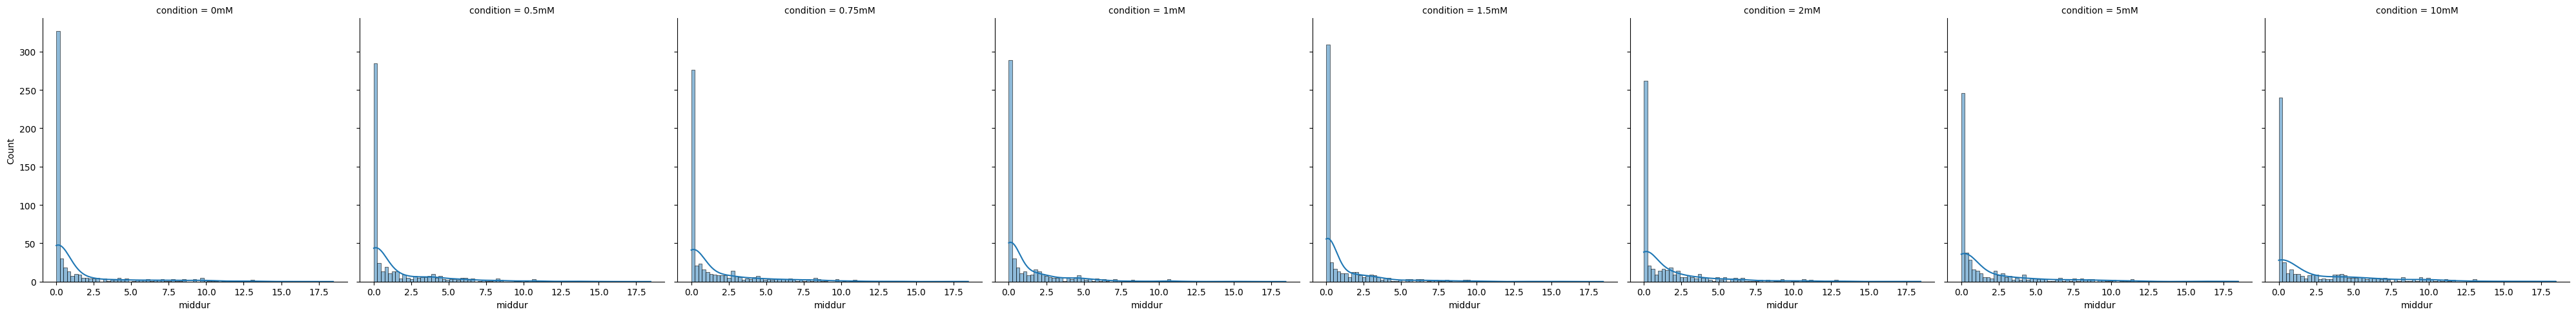

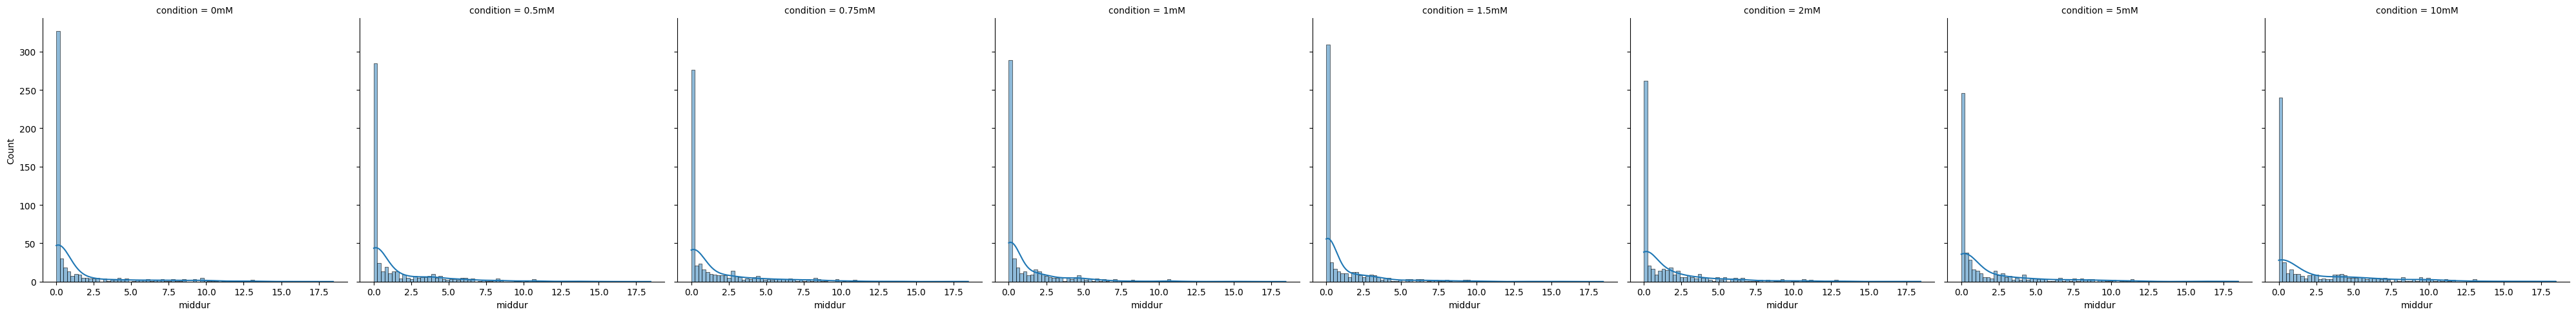

In [189]:
sns.displot(data=final_data, x="middur", col="condition", kde=True)
plt.show()

In [397]:
WT  = final_data[final_data['genotype']=='WT']
HET = final_data[final_data['genotype']=='HET']
HOM = final_data[final_data['genotype']=='HOM']

# make a custom list of colors
new_colors_order = sns.color_palette(palette='Set2', n_colors=3)
new_colors_order[0], new_colors_order[1], new_colors_order[2] = new_colors_order[1], new_colors_order[0], new_colors_order[2]


# Plot each year's time series in its own facet
g = sns.relplot(
    data=final_data,
    x="stdate_sttime", y="middur", col="condition", hue="genotype", hue_order=["WT","HET","HOM"],
    kind="line", palette=new_colors_order, linewidth=1, zorder=5,
    col_wrap=4, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for condition, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, condition, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=final_data, x="stdate_sttime", y="middur", units="condition",
        estimator=None, color=".9", linewidth=0.5, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_xticklabels(rotation=30)
g.set_axis_labels("", "Middur")
g.tight_layout()

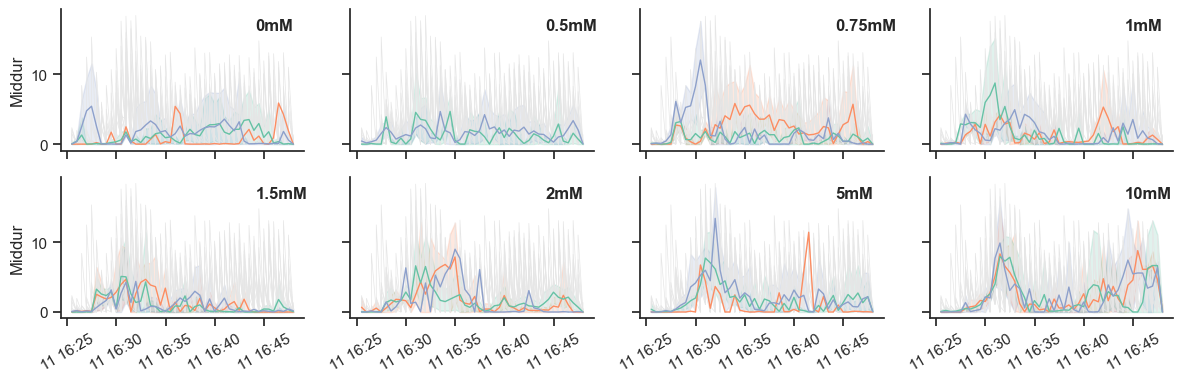

In [398]:
plt.show()

In [350]:
final_data['condition'].unique()

array(['0mM', '0.5mM', '0.75mM', '1mM', '1.5mM', '2mM', '5mM', '10mM'],
      dtype=object)

In [351]:
final_data.head()

,stdate_sttime,location,animal,start,end,middur,box,plate,well,genotype,condition,clock
0,2024-07-11 16:25:58,C001,1-A01,0,60.0,0.0,16,1,A1,HOM,0mM,7.432778
1,2024-07-11 16:25:58,C002,1-A02,0,60.0,0.0,16,1,A2,HET,0mM,7.432778
2,2024-07-11 16:25:58,C003,1-A03,0,60.0,0.0,16,1,A3,HOM,0mM,7.432778
3,2024-07-11 16:25:58,C004,1-A04,0,60.0,0.0,16,1,A4,HOM,0mM,7.432778
4,2024-07-11 16:25:58,C005,1-A05,0,60.0,0.0,16,1,A5,WT,0mM,7.432778


In [387]:

g = sns.FacetGrid(final_data, col="condition",  row="genotype", row_order=['WT','HET','HOM'], hue="genotype", hue_order=["HOM","WT","HET"])
g.map(sns.lineplot, "stdate_sttime","middur")
g.set_xticklabels(rotation=40)
g.tight_layout()

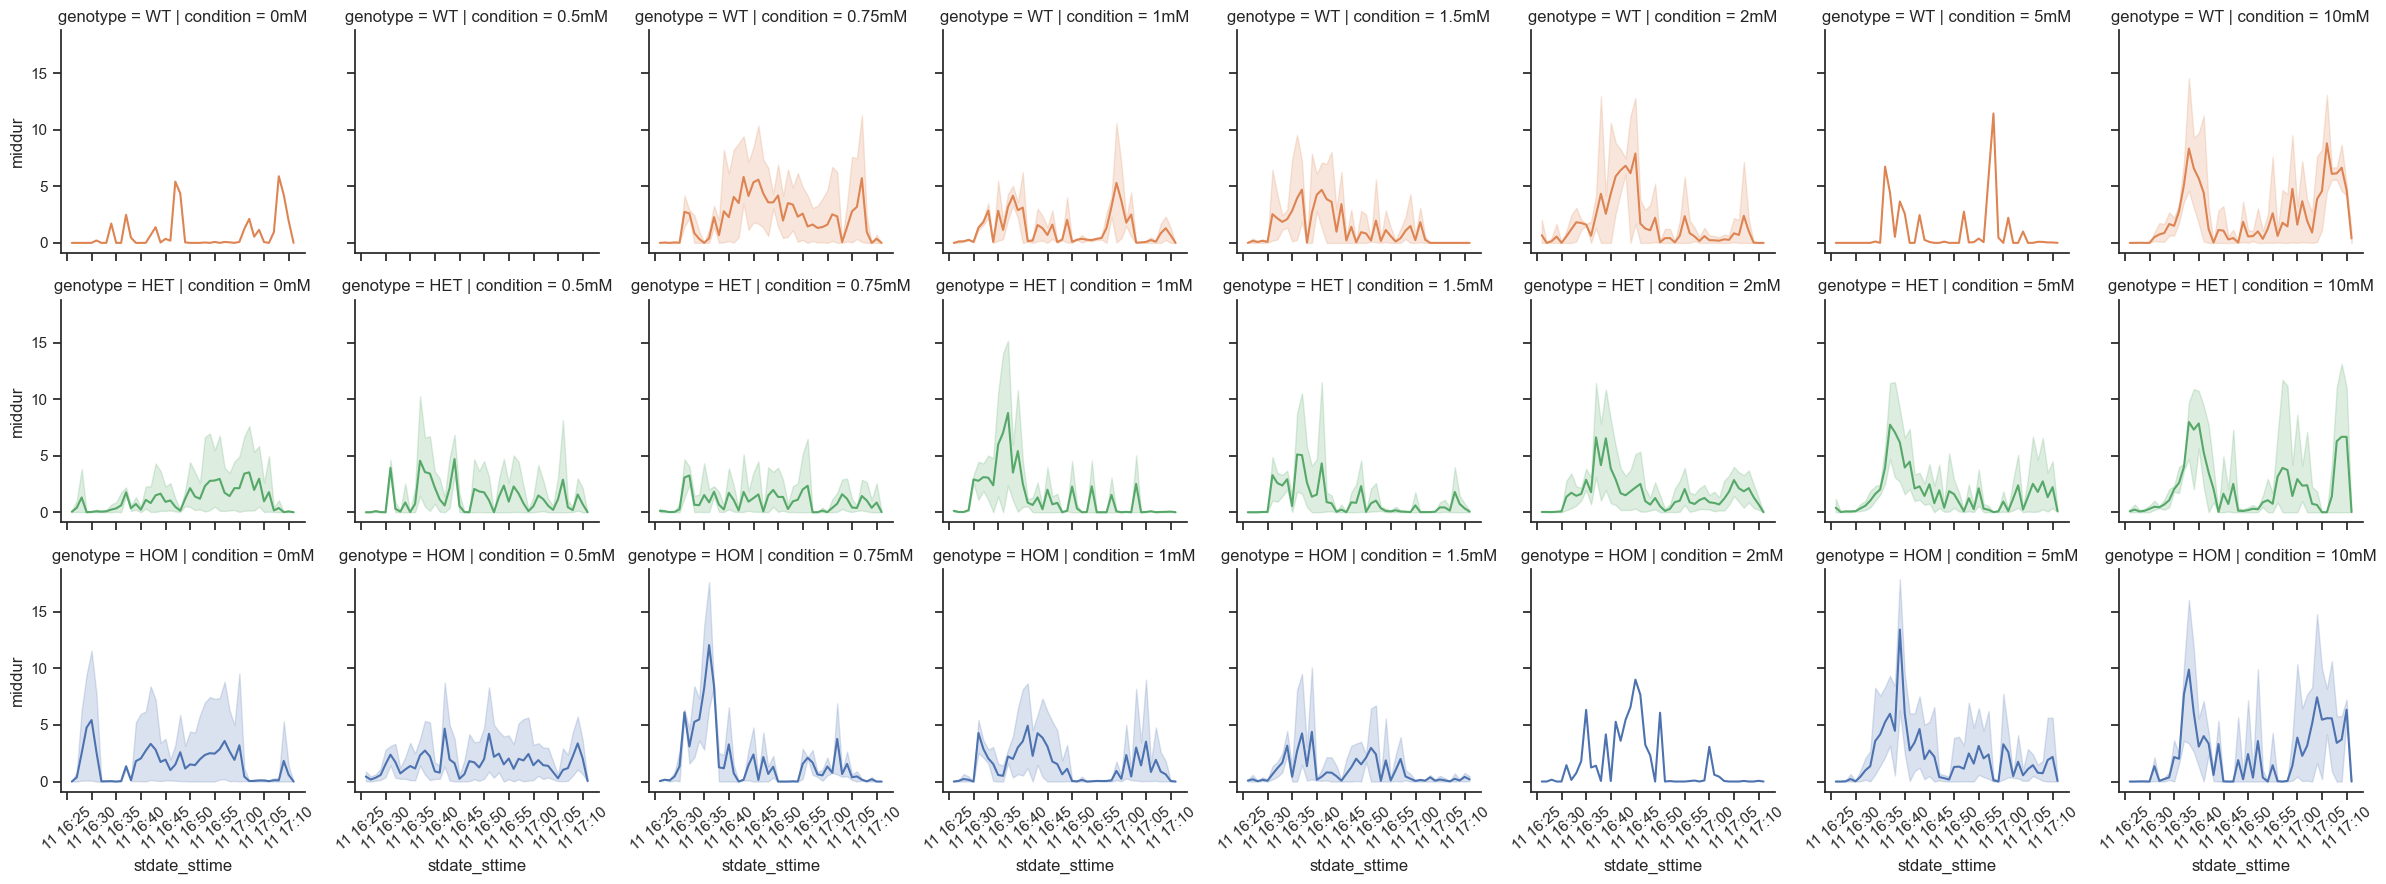

In [388]:
plt.show()

In [408]:
sns.displot(data=final_data, x="middur", col="condition",hue="genotype", hue_order=["WT","HET","HOM"], col_wrap=4, palette=new_colors_order, kde=True)

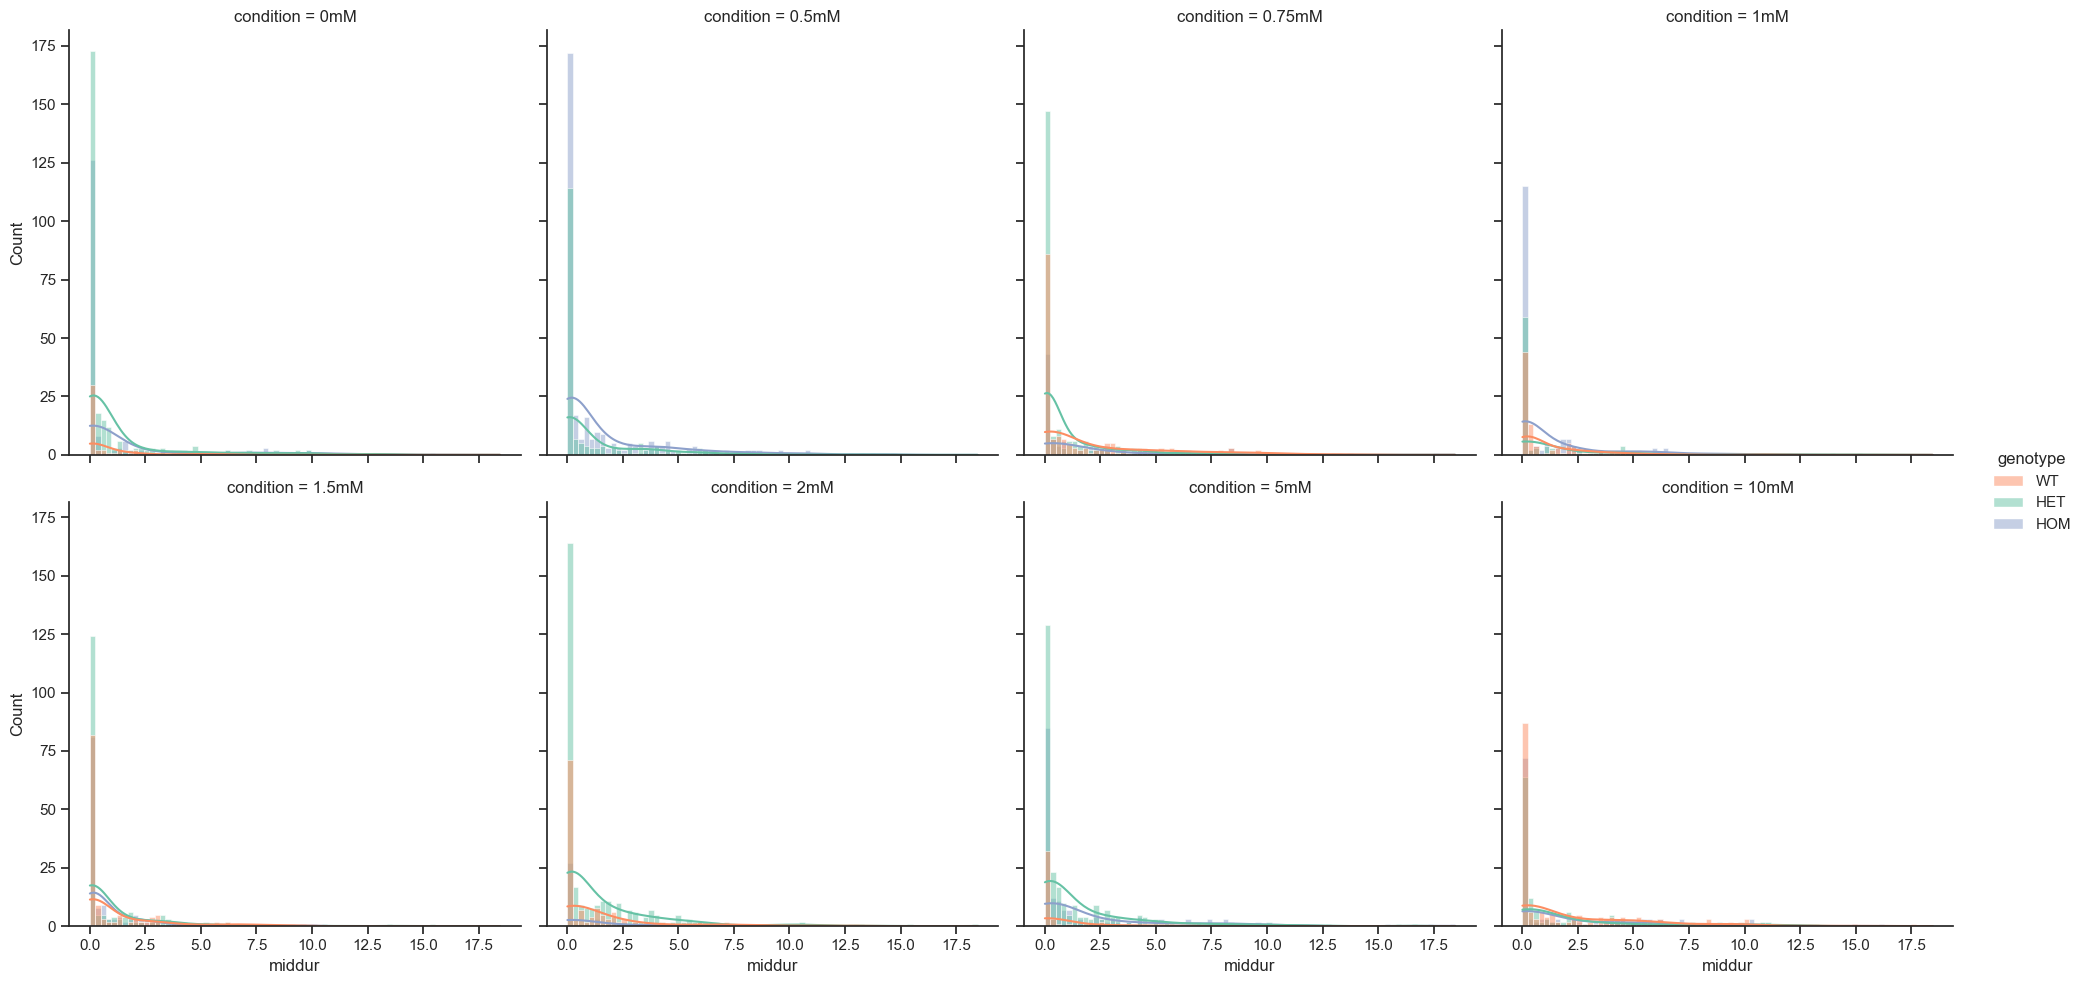

In [409]:
plt.show()